# Tutorial 3: Running Inference Step by Step

This tutorial demonstrates how to run inference step-by-step, breaking down the `inference.run()` command into its constituent parts. We'll:

1. Create mock data and a small bank
2. Select intrinsic samples based on chirp mass
3. Perform incoherent single-detector intrinsic sample selection
4. Visualize selected samples vs. original bank
5. Draw extrinsic samples
6. Perform coherent likelihood evaluations
7. Load and examine `prob_samples.feather`
8. Combine samples using `load_intrinsic_samples_from_rundir`
9. Standardize samples and create corner plots
10. Finally, show how to use `inference.run()` for a streamlined process


In [1]:
import sys
sys.path.append("../..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from cogwheel import data, gw_utils, gw_plotting, utils
from cogwheel.posterior import Posterior
from cogwheel.likelihood import RelativeBinningLikelihood
from dot_pe import inference, waveform_banks, config
from dot_pe.power_law_mass_prior import PowerLawIntrinsicIASPrior
from dot_pe.utils import load_intrinsic_samples_from_rundir

# Set up output directory
tutorial_dir = Path(".")


## Step 1: Create Mock Data and Small Bank

We'll use the methods from tutorial 1 and 2 to create a bank and generate an injection.


In [2]:
# Create 3-detector injection
eventname = "tutorial_inference_event"
event_data = data.EventData.gaussian_noise(
    eventname=eventname,
    detector_names="HLV",
    duration=120.0,
    asd_funcs=["asd_H_O3", "asd_L_O3", "asd_V_O3"],
    tgps=0.0,
    fmax=1600.0,
    seed=20223001, 
)

# Injection parameters
chirp_mass = 20.0
q = 0.7
m1, m2 = gw_utils.mchirpeta_to_m1m2(chirp_mass, gw_utils.q_to_eta(q))

injection_par_dic = dict(
    m1=m1,
    m2=m2,
    ra=0.5,
    dec=0.5,
    iota=np.pi / 3,
    psi=1.0,
    phi_ref=12.0,
    s1z=0.3,
    s2z=0.3,
    s1x_n=0.1,
    s1y_n=0.2,
    s2x_n=0.3,
    s2y_n=-0.2,
    l1=0.0,
    l2=0.0,
    tgps=0.0,
    f_ref=50.0,
    d_luminosity=2000.0,
    t_geocenter=0.0,
)

# Inject signal
event_data.inject_signal(injection_par_dic, "IMRPhenomXPHM")
snr = np.sqrt(2 * (event_data.injection["d_h"] - 0.5 * event_data.injection["h_h"]).sum())
print(f"Injection SNR: {snr:.2f}")

# Save event data
event_path = tutorial_dir / f"{eventname}.npz"
event_data.to_npz(filename=event_path, overwrite=True)
print(f"Saved event data to: {event_path}")


Injection SNR: 8.26
Saved event data to: tutorial_inference_event.npz


In [3]:
# Create a bank for tutorial
bank_dir = tutorial_dir / "bank"
bank_dir.mkdir(parents=True, exist_ok=True)

bank_size = 2**16
mchirp_min = 15
mchirp_max = 30
q_min = 0.2
f_ref = 50.0
seed = 777
n_pool = 4
blocksize = 4096
approximant = "IMRPhenomXPHM"

# Generate bank samples
powerlaw_prior = PowerLawIntrinsicIASPrior(
    mchirp_range=(mchirp_min, mchirp_max),
    q_min=q_min,
    f_ref=f_ref,
)

print(f"Generating {bank_size:,} bank samples...")
bank_samples = powerlaw_prior.generate_random_samples(
    bank_size, seed=seed, return_lnz=False
)

# Compute derived quantities and weights
bank_samples["mchirp"] = gw_utils.m1m2_to_mchirp(bank_samples["m1"], bank_samples["m2"])
bank_samples["lnq"] = np.log(bank_samples["m2"] / bank_samples["m1"])
bank_samples["chieff"] = gw_utils.chieff(
    *bank_samples[["m1", "m2", "s1z", "s2z"]].values.T
)
mchirp_values = bank_samples["mchirp"].values
bank_samples["log_prior_weights"] = 1.7 * np.log(mchirp_values)

# Save bank
bank_columns = [
    "m1", "m2", "s1z", "s1x_n", "s1y_n", "s2z", "s2x_n", "s2y_n", "iota", "log_prior_weights"
]
samples_path = bank_dir / "intrinsic_sample_bank.feather"
bank_samples[bank_columns].to_feather(samples_path)

# Save bank config
bank_config = {
    "bank_size": bank_size,
    "mchirp_min": mchirp_min,
    "mchirp_max": mchirp_max,
    "q_min": q_min,
    "f_ref": f_ref,
    "fbin": config.DEFAULT_FBIN.tolist(),
    "approximant": approximant,
    "m_arr": [2, 1, 3, 4],
    "seed": seed,
}
bank_config_path = bank_dir / "bank_config.json"
with open(bank_config_path, "w") as f:
    json.dump(bank_config, f, indent=4)

print(f"Saved bank to: {bank_dir}")
print(f"Bank size: {len(bank_samples):,} samples")


Generating 65,536 bank samples...
Saved bank to: bank
Bank size: 65,536 samples


In [4]:
# Generate waveforms (this may take a few minutes)
waveform_dir = bank_dir / "waveforms"
print(f"Generating waveforms using {n_pool} cores...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path,
    bank_config_path=bank_config_path,
    waveform_dir=waveform_dir,
    n_pool=n_pool,
    blocksize=blocksize,
    approximant=approximant,
)
print("Waveform generation complete!")


2025-12-09 14:48:23,968 - INFO - dot_pe.waveform_banks started at Tue Dec  9 14:48:23 2025


Generating waveforms using 4 cores...


2025-12-09 14:50:07,471 - INFO - dot_pe.waveform_banks finished after 104 seconds (1.73 minutes).


Waveform generation complete!


## Step 2: Select Intrinsic Samples Based on Chirp Mass

Select samples from the bank based on chirp mass: `mchirp_guess ± 8/snr * (mchirp_guess/10)^1.7`


In [5]:
# Load bank and compute chirp masses
bank_df = pd.read_feather(samples_path)
bank_mchirp = gw_utils.m1m2_to_mchirp(bank_df["m1"], bank_df["m2"])

# Chirp mass selection based on guess and SNR
mchirp_guess = chirp_mass  # Use injection chirp mass as guess
mchirp_window = 2 * (8 / snr) * (mchirp_guess / 10) ** 1.7
mchirp_min_select = mchirp_guess - mchirp_window
mchirp_max_select = mchirp_guess + mchirp_window

# Select indices
preselected_indices = np.where(
    (bank_mchirp >= mchirp_min_select) & (bank_mchirp <= mchirp_max_select)
)[0]

print(f"Chirp mass guess: {mchirp_guess:.2f}")
print(f"Selection window: [{mchirp_min_select:.2f}, {mchirp_max_select:.2f}]")
print(f"Selected {len(preselected_indices):,} samples from bank of {len(bank_df):,}")
print(f"Selection fraction: {len(preselected_indices)/len(bank_df):.1%}")


Chirp mass guess: 20.00
Selection window: [13.71, 26.29]
Selected 55,452 samples from bank of 65,536
Selection fraction: 84.6%


## Step 3: Incoherent Single-Detector Intrinsic Sample Selection

Perform incoherent single-detector likelihood evaluations to further filter samples.


In [6]:
# Set up inference parameters
n_int = len(bank_df)//4  # Use a quarter just for demonstration
n_phi = 32  # Number of phi_ref samples for single-detector evaluation
n_t = 128  # Number of time samples
single_detector_blocksize = 2048

# Create posterior to get par_dic_0 (matching inference.run() pattern)
fbin = np.array(bank_config["fbin"])
f_ref = bank_config["f_ref"]
posterior_kwargs = {
    "likelihood_class": RelativeBinningLikelihood,
    "approximant": approximant,
    "prior_class": "CartesianIASPrior",
}
likelihood_kwargs = {"fbin": fbin, "pn_phase_tol": None}
ref_wf_finder_kwargs = {"time_range": (-1e-1, +1e-1), "f_ref": f_ref}

posterior = Posterior.from_event(
    event=event_data,
    mchirp_guess=mchirp_guess,
    likelihood_kwargs=likelihood_kwargs,
    ref_wf_finder_kwargs=ref_wf_finder_kwargs,
    **posterior_kwargs,
)
par_dic_0 = posterior.likelihood.par_dic_0.copy()

print("Running incoherent single-detector selection...")
inds, lnlike_di, incoherent_lnlikes = inference.collect_int_samples_from_single_detectors(
    event_data=event_data,
    par_dic_0=par_dic_0,
    single_detector_blocksize=single_detector_blocksize,
    n_int=n_int,
    n_phi=n_phi,
    n_t=n_t,
    bank_folder=bank_dir,
    i_int_start=0,
    max_incoherent_lnlike_drop=20,
    preselected_indices=preselected_indices,
)

num_selected = len(inds)
frac_of_bank = num_selected / len(bank_df)
frac_of_preselected = num_selected / len(preselected_indices)
print(f"Selected {num_selected:,} intrinsic samples after incoherent filtering")
print(f"Fraction of original bank: {frac_of_bank:.2%}")
print(f"Fraction of preselected samples: {frac_of_preselected:.2%}")
print(f"Best incoherent lnL: {incoherent_lnlikes.max():.2f}")


Searching incoherent solution for tutorial_inference_event
Set intrinsic parameters, lnL = 42.53277844115344
Set time, lnL(L) = 24.244898789800423
Set sky location, lnL = 36.595418537266205
Set phase and distance, lnL = 36.595418537266205
Set mchirp_range = (np.float64(12.707848419938214), np.float64(31.86284120637423))
Running incoherent single-detector selection...


Processing intrinsic batches: 100%|██████████| 28/28 [02:16<00:00,  4.88s/it]

Selected 15,556 intrinsic samples after incoherent filtering
Fraction of original bank: 23.74%
Fraction of preselected samples: 28.05%
Best incoherent lnL: 42.83


Plot the samples selected and the bank

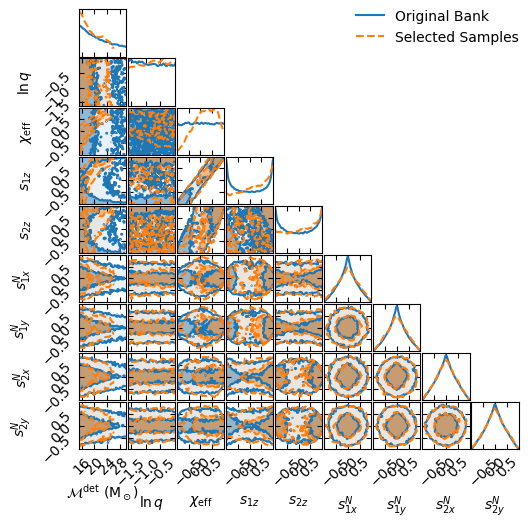

In [7]:
# Get selected samples from bank
selected_samples = bank_df.iloc[inds].copy()
selected_samples["mchirp"] = gw_utils.m1m2_to_mchirp(
    selected_samples["m1"], selected_samples["m2"]
)
selected_samples["lnq"] = np.log(selected_samples["m2"] / selected_samples["m1"])
selected_samples["chieff"] = gw_utils.chieff(
    *selected_samples[["m1", "m2", "s1z", "s2z"]].values.T
)

# Add mchirp, lnq, chieff to original bank for plotting
bank_df_plot = bank_df.copy()
bank_df_plot["mchirp"] = bank_mchirp
bank_df_plot["lnq"] = np.log(bank_df_plot["m2"] / bank_df_plot["m1"])
bank_df_plot["chieff"] = gw_utils.chieff(
    *bank_df_plot[["m1", "m2", "s1z", "s2z"]].values.T
)

# Create MultiCornerPlot
plot_params = ["mchirp", "lnq", "chieff", "s1z", "s2z", "s1x_n", "s1y_n", "s2x_n", "s2y_n"]
comparison_plot = gw_plotting.MultiCornerPlot(
    [bank_df_plot, selected_samples],
    params=plot_params,
    smooth=1.0,
    labels=["Original Bank", "Selected Samples"],
)
comparison_plot.plot(max_figsize=6)


## Step 5: Draw Extrinsic Samples

Generate extrinsic samples for coherent inference.


In [8]:
# Set up rundir for saving intermediate results
rundir = tutorial_dir / "run"
rundir.mkdir(parents=True, exist_ok=True)

# Save intrinsic sample indices
np.savez(
    rundir / "intrinsic_samples.npz",
    inds=inds,
    lnlikes_di=lnlike_di,
    incoherent_lnlikes=incoherent_lnlikes,
)

# Generate extrinsic samples
n_ext = 2**10  # Number of extrinsic samples
seed_ext = 1337

from dot_pe.coherent_processing import CoherentExtrinsicSamplesGenerator
from dot_pe.marginalization import MarginalizationExtrinsicSamplerFreeLikelihood
from cogwheel.waveform import WaveformGenerator

wfg = WaveformGenerator.from_event_data(event_data, approximant)
fbin = np.array(bank_config["fbin"])

marg_ext_like = MarginalizationExtrinsicSamplerFreeLikelihood(
    event_data, wfg, par_dic_0, fbin, coherent_score={"min_n_effective_prior": 100}
)

ext_sample_generator = CoherentExtrinsicSamplesGenerator(
    likelihood=marg_ext_like,
    intrinsic_bank_file=samples_path,
    waveform_dir=waveform_dir,
    seed=seed_ext,
)

get_marg_info_kwargs = {
    "save_marg_info": True,
    "save_marg_info_dir": rundir,
    "n_combine": 16,
    "indices": inds,
    "single_marg_info_min_n_effective_prior": 32,
}

print("Drawing extrinsic samples...")
extrinsic_samples, response_dpe, timeshift_dbe = (
    ext_sample_generator.draw_extrinsic_samples_from_indices(
        n_ext, get_marg_info_kwargs=get_marg_info_kwargs
    )
)

# Save extrinsic samples
extrinsic_samples.to_feather(rundir / "extrinsic_samples.feather")
np.save(arr=response_dpe, file=rundir / "response_dpe.npy")
np.save(arr=timeshift_dbe, file=rundir / "timeshift_dbe.npy")

print(f"Generated {len(extrinsic_samples):,} extrinsic samples")
print(f"Saved to: {rundir}")


2025-12-09 14:53:41 - Getting 16 MarginalizationInfo objects.


Drawing extrinsic samples...


Marginalization objects: 100%|██████████| 16/16 [00:06<00:00,  2.59obj/s, batches=1/487, accepted=16/16]
2025-12-09 14:53:49 - MarginalizationInfo object created!
2025-12-09 14:53:49 - Saving MarginalizationInfo object to run.


Generated 1,024 extrinsic samples
Saved to: run


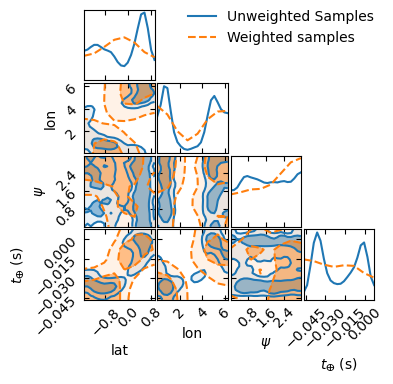

In [9]:
# Plot extrinsic parameters
ext_params = ["lat", "lon", "psi", "t_geocenter"]
extrinsic_samples_unweighted = extrinsic_samples.copy()
extrinsic_samples_unweighted["weights"] = 1 / len(extrinsic_samples_unweighted)
ext_plot = gw_plotting.MultiCornerPlot(
    [
        extrinsic_samples_unweighted,
        extrinsic_samples,
    ],
    params=ext_params,
    smooth=1.0,
    weights_col="weights",
    labels=[
        "Unweighted Samples",
        "Weighted samples",
    ],
)
ext_plot.plot(max_figsize=4.5)


## Step 7: Coherent Likelihood Evaluations

Perform coherent multi-detector likelihood evaluations.


In [10]:
# Run coherent inference
n_phi_coherent = 32  # Number of phi_ref samples for coherent evaluation
blocksize = 1024 # max number of intrinsic and extrinsic samples to evaluate 
# simultaneously
m_arr = np.array(bank_config["m_arr"])

print("Running coherent likelihood evaluations...")
ln_evidence, ln_evidence_discarded, n_effective, n_effective_i, n_effective_e, n_distance_marginalizations = (
    inference.run_coherent_inference(
        event_data=event_data,
        rundir=rundir,
        par_dic_0=par_dic_0,
        bank_folder=bank_dir,
        n_int=n_int,
        inds=inds,
        n_ext=n_ext,
        n_phi=n_phi_coherent,
        m_arr=m_arr,
        blocksize=blocksize,
        size_limit=10**6,
        max_bestfit_lnlike_diff=20,
    )
)

print("Coherent inference complete!")
print(f"  ln_evidence: {ln_evidence:.2f}")
print(f"  n_effective: {n_effective:.2f}")
print(f"  n_effective_i: {n_effective_i:.2f}")
print(f"  n_effective_e: {n_effective_e:.2f}")


Running coherent likelihood evaluations...
Creating 16 x 1 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]

Coherent inference complete!
  ln_evidence: 4.88
  n_effective: 11738.69
  n_effective_i: 135.75
  n_effective_e: 74.34


In [11]:
# Standardize samples (mimics what inference.run() does via postprocess)
samples = inference.postprocess(
    event_data=event_data,
    rundir=rundir,
    bank_folder=bank_dir,
    n_phi=n_phi_coherent,
    pr=posterior.prior,
    draw_subset=n_effective * 2 ,
)

# Save standardized samples
samples_path_final = rundir / "samples.feather"
samples.to_feather(samples_path_final)
print(f"Standardized samples saved to: {samples_path_final}")
print(f"Samples shape: {samples.shape}")

Standardizing samples...
Standardizing samples done in 0.835 seconds.
Standardized samples saved to: run/samples.feather
Samples shape: (5869, 48)


In [12]:
samples.columns

Index(['m1', 'm2', 's1z', 's1x_n', 's1y_n', 's2z', 's2x_n', 's2y_n', 'iota',
       'l1', 'l2', 'f_ref', 'lat', 'lon', '_phi_ref', 'psi',
       't_geocenter_linfree', 'i', 'e', 'o', 'lnl_marginalized',
       'ln_posterior', 'bestfit_lnlike', 'd_h_1Mpc', 'h_h_1Mpc', 'weights',
       'phi_ref_linfree', 't_geocenter', 'phi_ref', 'ra', 'dec',
       'd_luminosity', 'bestfit_d_luminosity', 'lnl', 'mchirp', 'lnq',
       'chieff', 'cumchidiff', 'costheta_jn', 'x1', 'y1', 'x2', 'y2',
       'costhetanet', 'phinet_hat', 't_refdet', 'phi_ref_hat', 'd_hat'],
      dtype='object')

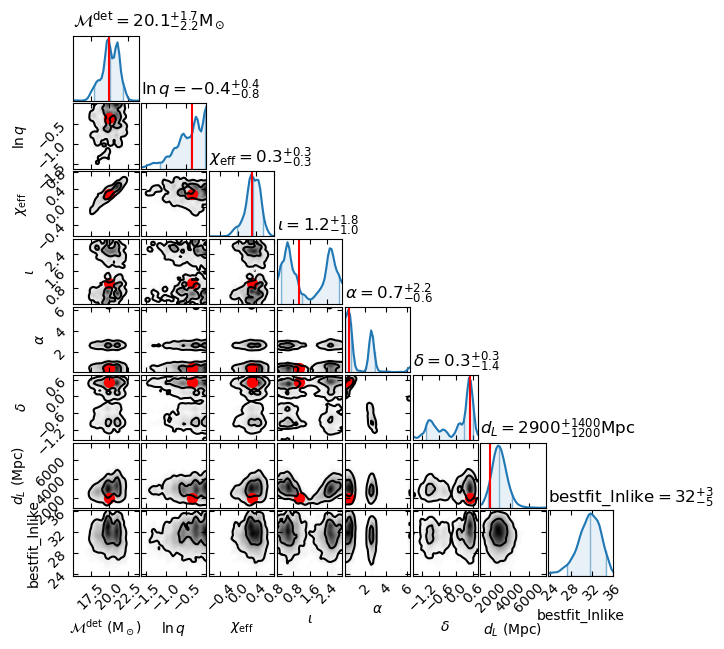

In [13]:
# Create corner plot with true injection parameters

# Compute true values for plotting
true_mchirp = gw_utils.m1m2_to_mchirp(injection_par_dic["m1"], injection_par_dic["m2"])
true_lnq = np.log(injection_par_dic["m2"] / injection_par_dic["m1"])
true_chieff = gw_utils.chieff(
    injection_par_dic["m1"],
    injection_par_dic["m2"],
    injection_par_dic["s1z"],
    injection_par_dic["s2z"],
)

true_values = injection_par_dic | {
    "mchirp": true_mchirp,
    "lnq": true_lnq,
    "chieff": true_chieff,
}

# Load standardized samples (created in previous cell)
samples = pd.read_feather(samples_path_final)

# Create corner plot

params = [
    "mchirp",
    "lnq",
    "chieff",
    "iota",
    "ra",
    "dec",
    "d_luminosity",
    "bestfit_lnlike",
]
corner_plot = gw_plotting.CornerPlot(
    samples,
    params=params,
    smooth=1.0,
)
corner_plot.plot(max_figsize=7)

# Add true injection parameters
corner_plot.scatter_points(
    true_values, colors="red", marker=".", s=200, label="Injection"
)


## Step 11: Streamlined Process Using inference.run()

Finally, here's how to use `inference.run()` to do everything in one streamlined call.


In [15]:
# Create a new rundir for streamlined run
streamlined_rundir = tutorial_dir / "run_streamlined"
streamlined_rundir.mkdir(parents=True, exist_ok=True)
n_int = len(bank_df)
n_ext = 1024
n_phi = 50
blocksize = 2048
single_detector_blocksize = 2048
# Run streamlined inference
print("Running streamlined inference with inference.run()...")
final_rundir = inference.run(
    event=event_data,
    bank_folder=bank_dir,
    n_int=n_int,
    n_ext=n_ext,
    n_phi=n_phi_coherent,
    n_t=n_t,
    blocksize=blocksize,
    single_detector_blocksize=single_detector_blocksize,
    seed=seed_ext,
    event_dir=str(streamlined_rundir),
    mchirp_guess=mchirp_guess,
    preselected_indices=None,
    max_incoherent_lnlike_drop=20,
    max_bestfit_lnlike_diff=20,
    draw_subset=True,
)

print("\nStreamlined inference complete!")
print(f"Results saved to: {final_rundir}")

# Load summary
summary_path = final_rundir / "summary_results.json"
summary = utils.read_json(summary_path)
print("\nSummary:")
print(f"  n_effective: {summary['n_effective']:.2f}")
print(f"  n_effective_i: {summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary['n_effective_e']:.2f}")
print(f"  ln_evidence: {summary['ln_evidence']:.2f}")

# Load final samples
final_samples = pd.read_feather(final_rundir / "samples.feather")
print(f"\nFinal samples shape: {final_samples.shape}")
print(f"Final samples saved to: {final_rundir / 'samples.feather'}")


Running streamlined inference with inference.run()...
Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for tutorial_inference_event
Set intrinsic parameters, lnL = 42.53277844115344
Set time, lnL(L) = 24.244898789800423
Set sky location, lnL = 36.595418537266205
Set phase and distance, lnL = 36.595418537266205
Set mchirp_range = (np.float64(12.707848419938214), np.float64(31.86284120637423))


Processing intrinsic batches: 100%|██████████| 32/32 [02:36<00:00,  4.90s/it]


16515 intrinsic samples selected.
Generating extrinsic samples...


2025-12-09 14:58:28 - Getting 16 MarginalizationInfo objects.
Marginalization objects: 100%|██████████| 16/16 [00:08<00:00,  1.88obj/s, batches=1/517, accepted=16/16]
2025-12-09 14:58:39 - MarginalizationInfo object created!
INFO:dot_pe.base_sampler_free_sampling_20251209-145828:MarginalizationInfo object created!
2025-12-09 14:58:39 - Saving MarginalizationInfo object to run_streamlined/run_0.
INFO:dot_pe.base_sampler_free_sampling_20251209-145828:Saving MarginalizationInfo object to run_streamlined/run_0.


Creating 9 x 1 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 9/9 [00:49<00:00,  5.51s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 1.31 seconds.
Saving samples to file...
Samples saved to:
 run_streamlined/run_0/samples.feather

Streamlined inference complete!
Results saved to: run_streamlined/run_0

Summary:
  n_effective: 18974.77
  n_effective_i: 128.81
  n_effective_e: 145.36
  ln_evidence: 3.53

Final samples shape: (9487, 48)
Final samples saved to: run_streamlined/run_0/samples.feather


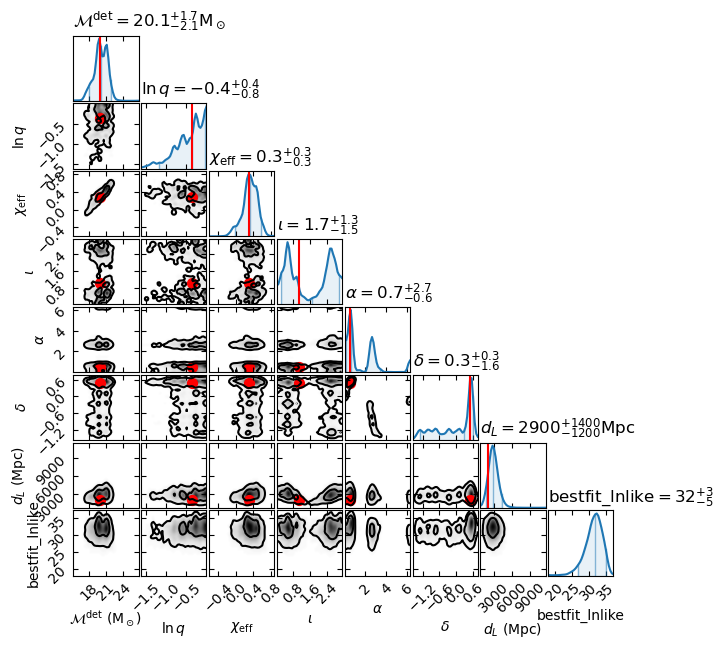

In [16]:
# Create corner plot with true injection parameters

# Compute true values for plotting
true_mchirp = gw_utils.m1m2_to_mchirp(injection_par_dic["m1"], injection_par_dic["m2"])
true_lnq = np.log(injection_par_dic["m2"] / injection_par_dic["m1"])
true_chieff = gw_utils.chieff(
    injection_par_dic["m1"],
    injection_par_dic["m2"],
    injection_par_dic["s1z"],
    injection_par_dic["s2z"],
)

true_values = injection_par_dic | {
    "mchirp": true_mchirp,
    "lnq": true_lnq,
    "chieff": true_chieff,
}

# Load standardized samples (created in previous cell)
samples = pd.read_feather("run_streamlined/run_0/samples.feather")

# Create corner plot

params = [
    "mchirp",
    "lnq",
    "chieff",
    "iota",
    "ra",
    "dec",
    "d_luminosity",
    "bestfit_lnlike",
]
corner_plot = gw_plotting.CornerPlot(
    samples,
    params=params,
    smooth=1.0,
)
corner_plot.plot(max_figsize=7)

# Add true injection parameters
corner_plot.scatter_points(
    true_values, colors="red", marker=".", s=200, label="Injection"
)
